In [46]:
import numpy as np
import torch.nn as nn
from ncps.wirings import AutoNCP
from ncps.torch import LTC
import pytorch_lightning as pl
import torch
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [24]:
# Fetching stock data from Yahoo Finance
ticker = 'AAPL'  # Example: Apple Inc.
stock_data = yf.download(ticker, start='2020-01-01', end='2023-01-01')
stock_data.reset_index(inplace=True)

[*********************100%%**********************]  1 of 1 completed


In [25]:
# Preparing the data
close_prices = stock_data['Close'].values
N = len(close_prices)  # Length of the time-series

In [26]:
# Creating sequences of 48 steps for input and the next step for output
sequence_length = 48
data_x = []
data_y = []
for i in range(len(close_prices) - sequence_length):
    data_x.append(close_prices[i:i+sequence_length])
    data_y.append(close_prices[i+sequence_length])

data_x = np.array(data_x).astype(np.float32)
data_y = np.array(data_y).astype(np.float32)
data_x = np.expand_dims(data_x, axis=-1)  # Add feature dimension
data_y = np.expand_dims(data_y, axis=-1)  # Add feature dimension

print("data_x.shape: ", str(data_x.shape))
print("data_y.shape: ", str(data_y.shape))

data_x.shape:  (708, 48, 1)
data_y.shape:  (708, 1)


In [27]:
# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(data_x, data_y, test_size=0.2, random_state=42)

In [28]:
# Create DataLoaders for training and testing
train_loader = DataLoader(TensorDataset(torch.Tensor(X_train), torch.Tensor(y_train)), batch_size=32, shuffle=True, num_workers=4)
test_loader = DataLoader(TensorDataset(torch.Tensor(X_test), torch.Tensor(y_test)), batch_size=32, shuffle=False, num_workers=4)

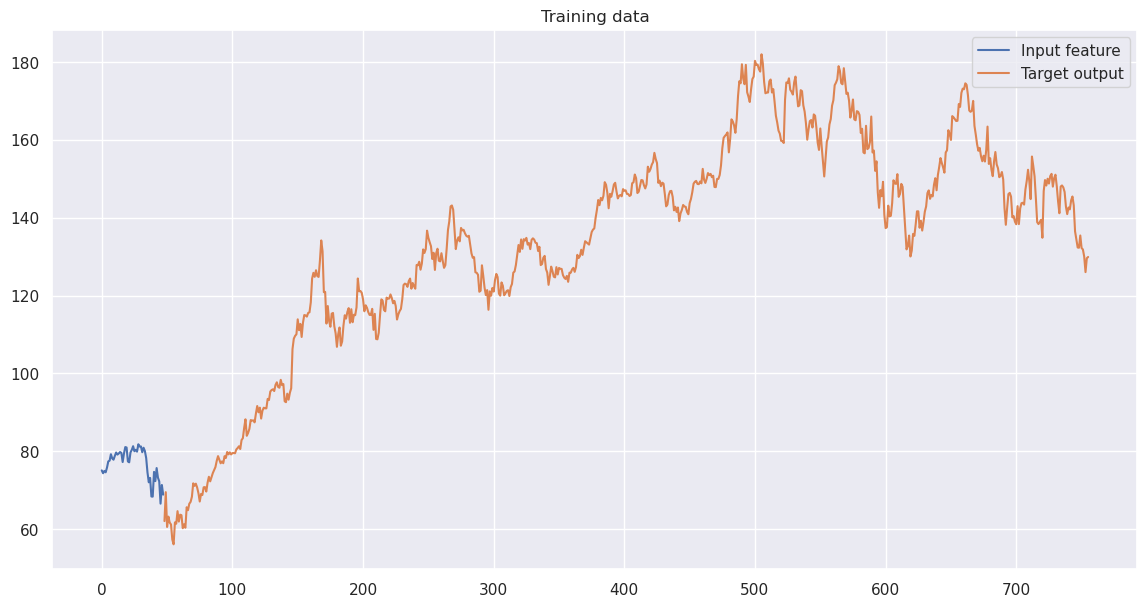

In [29]:
# Let's visualize the training data
sns.set_theme()
plt.figure(figsize=(14, 7))
plt.plot(data_x[0, :, 0], label="Input feature")
plt.plot(np.arange(sequence_length, sequence_length + len(data_y)), data_y[:, 0], label="Target output")
plt.title("Training data")
plt.legend(loc="upper right")
plt.show()

In [47]:
class SequenceLearner(pl.LightningModule):
    def __init__(self, model, lr=0.005):
        super().__init__()
        self.model = model
        self.lr = lr

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat, _ = self.model.forward(x)
        print(f"Shape of y: {y.shape}")
        print(f"Shape of y_hat before view_as: {y_hat.shape}")
        # Ensure y_hat is reshaped to match y
        y_hat = y_hat.view(y.size())
        print(f"Shape of y_hat after view_as: {y_hat.shape}")
        loss = nn.MSELoss()(y_hat, y)
        
        mse = mean_squared_error(y.cpu().numpy(), y_hat.cpu().detach().numpy())
        rmse = np.sqrt(mse)
        
        self.log("train_loss", loss, prog_bar=True)
        self.log("train_mse", mse, prog_bar=True)
        self.log("train_rmse", rmse, prog_bar=True)
        
        return {"loss": loss}

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat, _ = self.model.forward(x)
        y_hat = y_hat.view(y.size())
        loss = nn.MSELoss()(y_hat, y)
        
        mse = mean_squared_error(y.cpu().numpy(), y_hat.cpu().detach().numpy())
        rmse = np.sqrt(mse)
        
        self.log("val_loss", loss, prog_bar=True)
        self.log("val_mse", mse, prog_bar=True)
        self.log("val_rmse", rmse, prog_bar=True)
        
        return {"loss": loss}

    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat, _ = self.model.forward(x)
        y_hat = y_hat.view(y.size())
        loss = nn.MSELoss()(y_hat, y)
        
        mse = mean_squared_error(y.cpu().numpy(), y_hat.cpu().detach().numpy())
        rmse = np.sqrt(mse)
        
        self.log("test_loss", loss, prog_bar=True)
        self.log("test_mse", mse, prog_bar=True)
        self.log("test_rmse", rmse, prog_bar=True)
        
        return {"loss": loss}

    def configure_optimizers(self):
        return torch.optim.Adam(self.model.parameters(), lr=self.lr)

In [43]:
# The LTC model with NCP wiring
out_features = 1
in_features = 1

wiring = AutoNCP(16, out_features)  # 16 units, 1 motor neuron
ltc_model = LTC(in_features, wiring, batch_first=True)
learn = SequenceLearner(ltc_model, lr=0.01)
trainer = pl.Trainer(
    logger=pl.loggers.CSVLogger("log"),
    max_epochs=400,
    gradient_clip_val=1,  # Clip gradient to stabilize training
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


alloc!


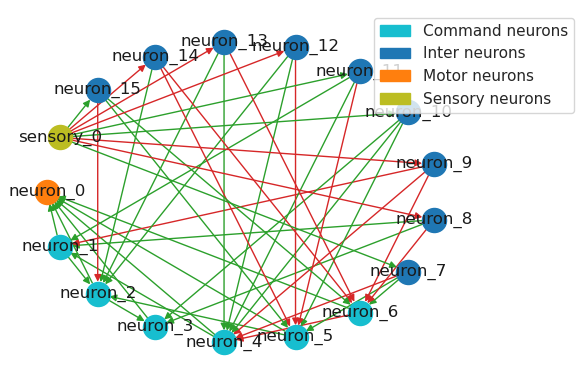

In [44]:
# Draw the wiring diagram of the network
sns.set_style("white")
plt.figure(figsize=(6, 4))
legend_handles = wiring.draw_graph(draw_labels=True, neuron_colors={"command": "tab:cyan"})
plt.legend(handles=legend_handles, loc="upper center", bbox_to_anchor=(1, 1))
sns.despine(left=True, bottom=True)
plt.tight_layout()
plt.show()

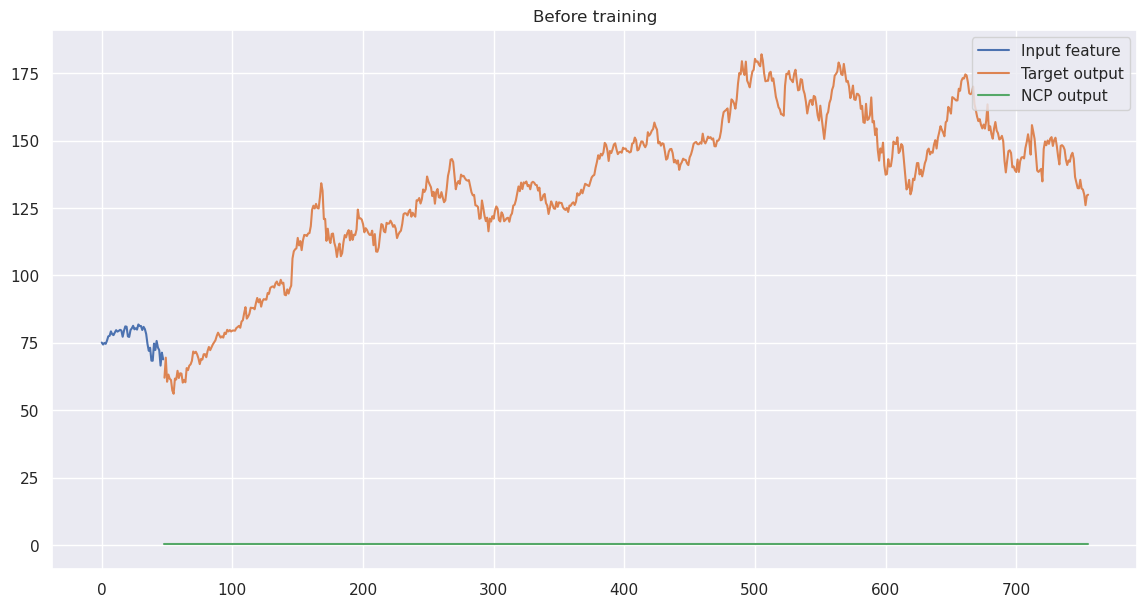

In [38]:
# Visualizing the prediction of the network before training
sns.set()
with torch.no_grad():
    prediction = ltc_model(torch.Tensor(data_x))[0].numpy()
plt.figure(figsize=(14, 7))
plt.plot(data_x[0, :, 0], label="Input feature")
plt.plot(np.arange(sequence_length, sequence_length + len(data_y)), data_y[:, 0], label="Target output")
plt.plot(np.arange(sequence_length, sequence_length + len(data_y)), prediction[:, 0], label="NCP output")
plt.title("Before training")
plt.legend(loc="upper right")
plt.show()

In [48]:
# Training the model
trainer.fit(learn, train_loader, val_dataloaders=test_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type | Params
-------------------------------
0 | model | LTC  | 1.4 K 
-------------------------------
1.1 K     Trainable params
272       Non-trainable params
1.4 K     Total params
0.006     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

RuntimeError: shape '[32, 1]' is invalid for input of size 1536

In [40]:

# Evaluate model on test set
trainer.test(learn, test_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

RuntimeError: shape '[32, 1]' is invalid for input of size 1536

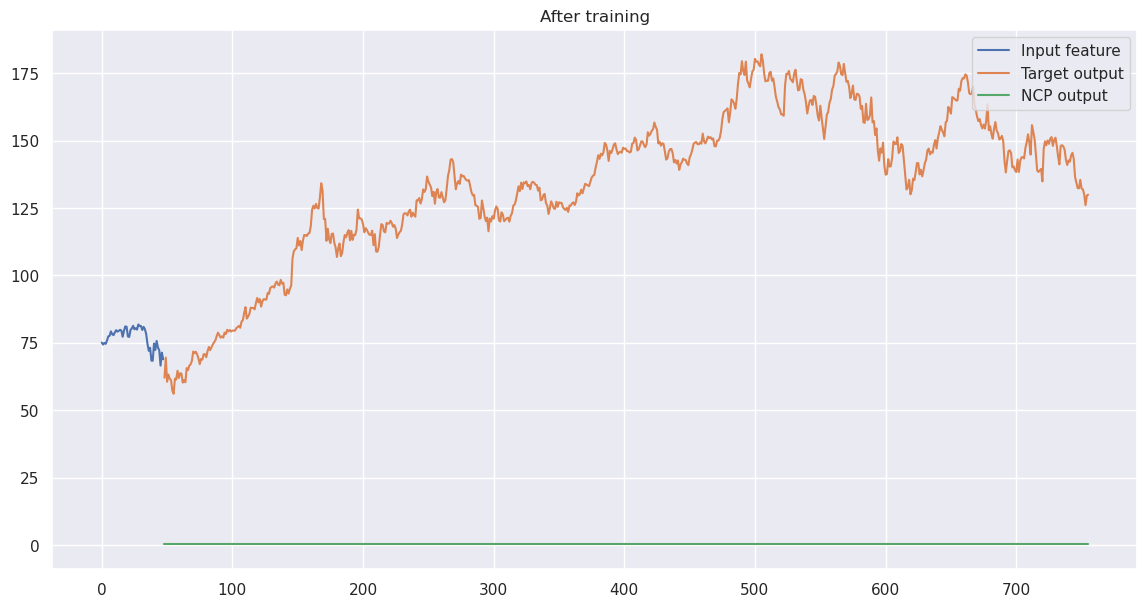

In [41]:
# How does the trained model now fit to the stock price data?
sns.set_theme()
with torch.no_grad():
    prediction = ltc_model(torch.Tensor(data_x))[0].numpy()
plt.figure(figsize=(14, 7))
plt.plot(data_x[0, :, 0], label="Input feature")
plt.plot(np.arange(sequence_length, sequence_length + len(data_y)), data_y[:, 0], label="Target output")
plt.plot(np.arange(sequence_length, sequence_length + len(data_y)), prediction[:, 0], label="NCP output")
plt.title("After training")
plt.legend(loc="upper right")
plt.show()